<a href="https://colab.research.google.com/github/Henning-Kubatzsch/Tutorials/blob/main/Makemore/04_MakeMoreShort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Going deeper into Backpropagation - 'leaky abstraction'

## Leaky Abstraction in Deep Learning



When using deep learning frameworks like PyTorch or TensorFlow, much of the complexity (like backpropagation) is hidden behind **convenient abstractions**. But here’s the catch:

### Leaky Abstraction

* These abstractions can **leak**—meaning:
  They don’t protect you from low-level details when something breaks.
* If you **don’t understand how backpropagation works**, you can:

  * Misuse layers or gradients
  * Misinterpret losses
  * Struggle debugging exploding/vanishing gradients
  * Have silent bugs (e.g., wrong shapes, detached tensors, etc.)

---

### Karpathy’s Key Message

> *“Yes, you should understand backprop.”*
> From [Karpathy’s blog post](https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b):

* Don’t just rely on `.backward()`.
* Know what’s actually happening:

  * How gradients flow
  * What each operation contributes
  * Why certain things break during training

---

### TL;DR:

* Deep learning tools are powerful—but if you use them blindly, you can shoot yourself in the foot.
* Understand the internals (especially backpropagation) to debug and build models **confidently**.



# Initilize Data

In [83]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [84]:
# read in all words
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt -O names.txt
words = open('names.txt').read().splitlines()

--2025-06-04 13:45:03--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2025-06-04 13:45:03 (7.36 MB/s) - ‘names.txt’ saved [228145/228145]



In [85]:
# build the vocabulary of characters and mappings to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


# Generate Dataset - using Splits

In [86]:
# built dataset
block_size = 3

def build_dataset(words):
  X, Y = [], []

  for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

#print(len(words[:n1]))
#print(len(words[n1:n2]))
#print(len(words[n2:]))


Xtr, Ytr = build_dataset(words[:n1])      # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])      # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Network Initilization and Hints for this exercise




## Initialization & Debugging: Key Insights

### Initialization Strategy:

* **W2, b2, bngain, bnbias** should be initialized to **small values** (e.g., Gaussian with small std).
* This keeps activations and gradients from exploding in early training.

### Why Biases Aren’t Zero (Even Though That’s Common):

* Biases are **typically initialized to 0**, but…
* **Zero-initialized biases can silently hide bugs**, especially in:

  * gradient flow
  * weight updates
  * batchnorm interactions

So instead, we **use small non-zero values** (e.g., 0.01) for debugging:

* It ensures that gradients flow and changes actually happen.
* If something breaks or doesn’t learn, it's easier to see why.

---

### Why Keep `b1` At All?

* Even though **`b1` is overridden by batch norm**, we might **keep it in the model for completeness or architectural clarity**.
* It won’t hurt performance, but it **doesn’t affect output** either (because batch norm subtracts the mean anyway).

---

### Summary:

| Parameter | Init Strategy       | Reason                                   |
| --------- | ------------------- | ---------------------------------------- |
| `W2`      | Small random        | Prevent exploding activations            |
| `b2`      | Small non-zero      | Avoid masking gradient bugs              |
| `bngain`  | All 1s              | Starts with identity scaling             |
| `bnbias`  | Small non-zero      | Starts with slight offset, aids learning |
| `b1`      | Included but unused | For completeness/documentation           |


## Initilize Hyperparameters

In [87]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
# embedding matrix: translates discreate input to continuous vectors
C = torch.randn((vocab_size, n_embd),             generator=g)

W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * (5/3) / ((n_embd * block_size) ** 0.5)
b1 = torch.randn(n_hidden,                        generator = g) * 0.1 # using b1 just for fun, it's useless beause of ...

# make logits very small by scaling them down towards zero
W2 = torch.randn((n_hidden, vocab_size),          generator = g) * 0.1
# we make all biases in b2 zero
b2 = torch.randn(vocab_size,                      generator = g) * 0.1

# BatchNorm parameters
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

batch_size = 32
n = batch_size # s shorter variable also, for convenience
# construct minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

4137


## Run the NN

### Forward and Backward Passes

This section dives deep into how neural networks *really* learn by explicitly walking through the **forward and backward passes**—without relying on automatic tools like `F.cross_entropy`. Here's what to expect:

---

#### 1. **Forward Pass: More Detailed**

* You’ll manually implement each step of the forward pass.
* Instead of using built-in helpers like `F.cross_entropy`, you’ll:

  * **Compute logits → probabilities**
  * **Calculate log probabilities**
  * **Compute the actual loss**

This makes every transformation **explicit and visible**.

---

#### 2. **Manual Loss Function**

* The loss isn’t a single-line function anymore.
* Instead, it’s broken down into **many sub-steps**—each producing intermediate tensors.
* Example intermediates:

  * `logprobs`, `probs`, `bnraw`, etc.

---

#### 3. **Backward Pass: Tensor-by-Tensor Derivatives**

* You’ll calculate how the **loss changes** with respect to every intermediate tensor.
* These are the partial derivatives we usually let PyTorch handle.
* For each forward operation, you’ll write the **matching backward step**:

  * How does the loss change if that tensor changes slightly?
  * This helps you **understand gradient flow**, not just use it.

---

#### 4. **Building Intuition**

* You’ll see how:

  * Each tensor impacts the final output.
  * Gradients are “passed backward” layer by layer.
* This gives you deep insight into what’s going on *under the hood* of PyTorch or TensorFlow.



In [88]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embd the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation (32, 200)
# BatchNorm layer
bnmeani = 1/n * hprebn.sum(0, keepdim = True) # mini-batch mean for every neuron
bndiff = hprebn - bnmeani # (32, 200)
bndiff2 = bndiff ** 2  # (32, 200)
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n), mini-batch variance
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv  # normaize (xhead)
hpreact = bngain * bnraw + bnbias # scale and shift

# Non-linear layer
h = torch.tanh(hpreact) # hidden layer

# Linear Layer 2
logits = h @ W2 + b2

# cross entropy loss (same as F.cross_entropy(logits, Yb))
# probs = torch.softmax(logits, dim = 0) #softmax: exp() -> Normalization
logit_maxes = logits.max(1, keepdim = True).values # (32, 1)
norm_logits = logits - logit_maxes # substract max for numerical stability (32, 27)
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims = True)
counts_sum_inv = counts_sum ** -1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv # (32, 27)
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no clearner way | afaik: as far as i know
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
          bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
          embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3281, grad_fn=<NegBackward0>)

### Bessel's Correction in Batch Normalization



#### The Two Types of Variance:

When calculating variance in a batch, there are two common formulas:

* **Biased Estimate**:
  $\frac{1}{n} \sum (x_i - \bar{x})^2$
  → Tends to **underestimate** the true variance, especially with small sample sizes

* **Unbiased Estimate (Bessel's Correction)**:
  $\frac{1}{n-1} \sum (x_i - \bar{x})^2$
  → Corrects the bias; gives a more **accurate** estimate of the population variance

---

#### Why This Matters in BatchNorm

> The way you compute variance during training **should match** what you do during inference.

If you:

* Use biased variance during training
* Use unbiased variance during evaluation
  → You introduce **inconsistency** in your model’s behavior.

---

#### Karpathy’s Recommendation:

> Always use **unbiased variance**:
> $\frac{1}{n - 1}$
> – both during **training and testing**

Especially important when:

* **Batch sizes are small**
* You want the **most stable and generalizable** performance

---

#### PyTorch Behavior:

* By default, `torch.var(..., unbiased=True)`
  → So PyTorch **already does the right thing** for you

---

#### TL;DR:

* Use **unbiased variance** in BatchNorm to get more accurate statistics.
* Prevents subtle bugs and training/evaluation mismatches.
* PyTorch handles this correctly by default — but be aware in custom implementations.


BatchNorm Variance & Bessel's Correction:

$bnvar = \frac{1}{n-1}\sum(x_i - \bar{x})^2$

Kapapthy's Recommandation:
- Use unbiased variance (1 / (n - 1)) both during training and testing

- It avoids the inconsistency seen when mixing biased/unbiased across phases

- Using unbiased variance is especially important when working with small batches, since biased estimators tend to underestimate the true variance


Pytorch Behaviour:
- Pytorch uses unbiased variance by default

# Evaluation Function

In [89]:
# utility function we will use larer when comaring manual gradients to PyTorch gradients
def cmp(s, dt, t):
  #print(dt)
  #print(t.grad)
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad) # maybe they are close?
  maxdiff = (dt - t.grad).abs().max().item() # what is the largest difference
  print(f'{s:15s} | exact:{str(ex):5s} | approximate: {str(app):5s} | madsiff: {maxdiff}')

- here we will caclculate the local derivatives of every operation in the neural net
- also we will take the long route and not use F.cross_entropy

# Exercise 1: Atomic Backpropagation

## Goal:

We’re going to **manually compute the gradients** (aka local derivatives) for each operation in our neural network — **step by step**, no shortcuts!



## Short from Karpathy

In [90]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1.0 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff += (2*bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k,j]
    dC[ix] += demb[k,j]

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact:True  | approximate: True  | madsiff: 0.0
probs           | exact:True  | approximate: True  | madsiff: 0.0
counts_sum_inv  | exact:True  | approximate: True  | madsiff: 0.0
counts_sum      | exact:True  | approximate: True  | madsiff: 0.0
counts          | exact:True  | approximate: True  | madsiff: 0.0
norm_logits     | exact:True  | approximate: True  | madsiff: 0.0
logit_maxes     | exact:True  | approximate: True  | madsiff: 0.0
logits          | exact:True  | approximate: True  | madsiff: 0.0
h               | exact:True  | approximate: True  | madsiff: 0.0
W2              | exact:True  | approximate: True  | madsiff: 0.0
b2              | exact:True  | approximate: True  | madsiff: 0.0
hpreact         | exact:False | approximate: True  | madsiff: 4.656612873077393e-10
bngain          | exact:False | approximate: True  | madsiff: 1.862645149230957e-09
bnbias          | exact:False | approximate: True  | madsiff: 2.7939677238464355e-09
bnraw           | exa

## Local Derivatives - Long version - Me working it out


### dlogprobs

In [91]:
logprobs[range(n), Yb].shape # (32)
# loss = -(a + b + c) / 3 = -1/3a + -1/3b + -1/3c
# dloss/ da = -1/3 -> -1/n
# derivation/ the gradient for all elements in logprobs[range(n), Yb] is - 1/n
# for all other elements in logprobs the gradient is intutively 0, means: if change those other numbers the loss does not change

# creates matrix of zeros in shape of logprobs
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1/n



### dprobs

In [92]:
# probs = counts * counts_sum_inv
probs.shape #(32, 27)
dprobs = torch.zeros_like(probs)

dprobs = (1.0 / probs) * dlogprobs

### dcounts_sum_inv

In [93]:
counts.shape, counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [94]:
# probs = counts * counts_sum_inv
# pytorch will do an implicit broasdcasting

# c = a * b, but with tensors
# a[3x3] * b[3x1]
# a11*b1 a12*b1 a13*b1
# a21*b2 a22*b2 a23*b2
# a31*b3 a32*b3 a33*b3
# c[3x3]

# here we have 2 operations as pytorch first brings colum vector to matrix shape, then does the multiplication
# we start with the multiplication

# if you broadcast over a tensor in forward, you must sum over this tensor in backward
# probs = counts * counts_sum_inv # (32, 27)
# -> (product rule) dprobs = counts * d(counts_sum_inv) + d(counts) * counts_sum_inv
# dprobs/ d(counts_sum_inv) = counts
# use chain rulse -> counts * dprobs
# then sum over dimension you broadcasted before
dcounts_sum_inv = (counts * dprobs).sum(1, keepdims=True)

### dcounts_sum

In [95]:
dcounts_sum = -1 * (counts_sum)**(-2)*dcounts_sum_inv

### dcounts

In [96]:
# this is from: probs = counts * counts_sum_inv
dcounts =  counts_sum_inv * dprobs

# ... as counts is also used to calculate counts_sum_inv we need to calculate the second contribution (counts_sum_inv) first



In [97]:
# this is from: counts_sum = counts.sum(1, keepdim = True)
counts.shape, counts_sum.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

...dcounts must have shape (32, 27)

In [98]:
# What is this operatio doing
# a11 a12 a13   ---> b1 (= a11 + a12 + a13)
# a21 a22 a23   ---> b2 (= a21 + a22 + a23)
# a31 a32 a33   ---> b1 (= a31 + a32 + a33)

# dcounts = torch.ones_like(counts) * dcounts_sum
# but as we calculated dcounts before we must be carefull that we add the gradients

dcounts += torch.ones_like(counts) * dcounts_sum

### dnorm_logits

In [99]:
# dnorm_logits = norm_logits.exp() * dcounts
dnorm_logits = counts * dcounts

### dlogits_maxes

In [100]:
dlogit_maxes = (-dnorm_logits).sum(1, keepdim = True)

In [101]:
# dlogit_maxes

### dlogits

In [102]:
# 1: norm_logits = logits - logits_maxes
dlogits = dnorm_logits.clone()

# 2: logits_maxes = logits.max(1, keepdim = True)
# logits.max(1, keepdim= True) gives back the max value of each row and there indices

dlogits2 = torch.zeros_like(logits)
dlogits2[range(n), logits.max(1, keepdim=True).indices] = 1
dlogits += dlogits2 * dlogit_maxes

Short Version from Karpathy
- with the other version you have issues with the floating point operations
  - int Test derivatives you get exact: False | approximate: True

In [103]:
dlogits = dnorm_logits.clone()
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

to get image representative:

In [104]:
logits.shape[1]

27

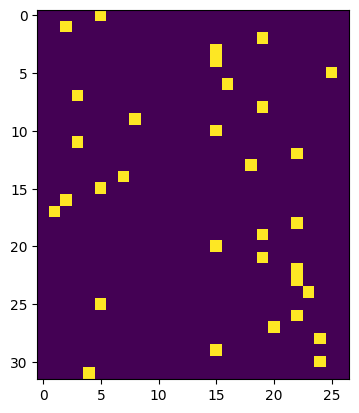

In [105]:
plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]))

During the backward pass, the vector logits_maxes is duplicated into a matrix, and the values in each row are routed to the activated bits.

### dh

Karpathy can never remeber how to backprop through matrix mul. but it is easy as just the dimensions have to work out

In [106]:
dlogits.shape, h.shape, W2.shape, b2.shape


(torch.Size([32, 27]),
 torch.Size([32, 64]),
 torch.Size([64, 27]),
 torch.Size([27]))

In [107]:
dh = dlogits @ W2.T

### dW2

In [108]:
logits.shape, h.shape, W2.shape, b2.shape


(torch.Size([32, 27]),
 torch.Size([32, 64]),
 torch.Size([64, 27]),
 torch.Size([27]))

In [109]:
dW2 = h.T @ dlogits

### db2

In [110]:
db2 = dlogits.sum(0, keepdim=True)

### dhpreact

In [111]:
dhpreact = (1.0 - h**2) * dh

### dbngain

In [112]:
dbngain = (bnraw * dhpreact).sum(0, keepdim = True)
dbngain.shape, bngain.shape

(torch.Size([1, 64]), torch.Size([1, 64]))

### dbnraw


In [113]:
dbnraw = bngain * dhpreact

### dbnbias

In [114]:
dbnbias = ((1) * dhpreact).sum(0, keepdim = True)

In [115]:
bnbias.shape, dbnbias.shape

(torch.Size([1, 64]), torch.Size([1, 64]))

### dbnvar_inv

In [116]:
bnvar_inv.shape,

(torch.Size([1, 64]),)

In [117]:
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim = True)

### dbnvar

In [118]:
dbnvar = -0.5 * (bnvar + 1e-5)**(-1.5) * dbnvar_inv
bnvar.shape, dbnvar.shape

(torch.Size([1, 64]), torch.Size([1, 64]))

### dbndiff2

We find a kind of pattern in a.sum().
- every time we have a .sum in a forward pass that turns into a replication or broadcasting in the backward pass along the same dimension
- conversly, if we have a replication or a broadcasting in the forward pass that indicates a variable reuse
  - in the backward pass that turns into a sum over the exact same dimension

In [119]:
# a11 a12
# a21 a22
# --->
# b1  b2, where:
# b1 = 1/(n-1) * (a11 + a21)
# b2 = 1/(n-1) * (a12 + a22)

In [120]:
dbndiff2 = (1/ (n-1)) * torch.ones_like(bndiff2) * dbnvar

In [121]:
bndiff2.shape, dbndiff2.shape, bnvar.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

### dbndiff


In [122]:
dbndiff = bnvar_inv * dbnraw
dbndiff += 2*bndiff * dbndiff2

### dbnmeani

In [123]:
dbnmeani = (-1 * dbndiff).sum(0, keepdim = True)

In [124]:
bnmeani.shape, dbnmeani.shape

(torch.Size([1, 64]), torch.Size([1, 64]))

### dhprebn

In [125]:
dhprebn = dbndiff.clone()
dhprebn += (1/n) * dbnmeani
# other possibility:
# dhprebn += torch.ones_like(hprebn) * (1/n) * dbnmeani

In [126]:
dhprebn.shape, hprebn.shape

(torch.Size([32, 64]), torch.Size([32, 64]))

### dembcat

In [127]:
embcat.shape, W1.shape, b1.shape, dhprebn.shape

(torch.Size([32, 30]),
 torch.Size([30, 64]),
 torch.Size([64]),
 torch.Size([32, 64]))

In [128]:
dembcat = dhprebn @ W1.T

### dW1

In [129]:
embcat.shape, W1.shape, b1.shape, dhprebn.shape

(torch.Size([32, 30]),
 torch.Size([30, 64]),
 torch.Size([64]),
 torch.Size([32, 64]))

In [130]:
dW1 = embcat.T @ dhprebn

### db1

In [131]:
embcat.shape, W1.shape, b1.shape, dhprebn.shape

(torch.Size([32, 30]),
 torch.Size([30, 64]),
 torch.Size([64]),
 torch.Size([32, 64]))

In [132]:
db1 = dhprebn.sum(0, keepdim=True)

### demb

In [133]:
# forward pass: embcat = emb.view(emb.shape[0], -1)

In [134]:
dembcat.shape, emb.shape

(torch.Size([32, 30]), torch.Size([32, 3, 10]))

In [135]:
demb = dembcat.view(emb.shape)

### dC


* For each of the selected rows from matrix C (10 rows), we now have their gradients arranged in a (32, 3, 10) tensor.
* Our next step is to route these gradients backward through the assignment operation.
* We need to identify which row of C each of these 10-dimensional embeddings came from, and then accumulate their gradients into the corresponding positions in dC.

  * This means we have to reverse the indexing process, and if any row of C was used multiple times, we must sum the gradients that arrive there.



In [136]:
# forward: emb = C[Xb]
print(emb.shape, C.shape, Xb.shape)
print(Xb[:5])

torch.Size([32, 3, 10]) torch.Size([27, 10]) torch.Size([32, 3])
tensor([[ 1,  1,  4],
        [18, 14,  1],
        [11,  5,  9],
        [ 0,  0,  1],
        [12, 15, 14]])


In [137]:
Xb[1,1], Xb[1][1]

(tensor(14), tensor(14))

In [138]:
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k,j] # same as Xb[k][j]
    dC[ix] += demb[k,j]

## Test derivatives

In [139]:
# Exercise 1: backprob through the whole thing manually,
# backpropagation through exactly all of the variables
# as the are defined in the forward pass above, one by one–

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('bhprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact:True  | approximate: True  | madsiff: 0.0
probs           | exact:True  | approximate: True  | madsiff: 0.0
counts_sum_inv  | exact:True  | approximate: True  | madsiff: 0.0
counts_sum      | exact:True  | approximate: True  | madsiff: 0.0
counts          | exact:True  | approximate: True  | madsiff: 0.0
norm_logits     | exact:True  | approximate: True  | madsiff: 0.0
logit_maxes     | exact:True  | approximate: True  | madsiff: 0.0
logits          | exact:True  | approximate: True  | madsiff: 0.0
h               | exact:True  | approximate: True  | madsiff: 0.0
W2              | exact:True  | approximate: True  | madsiff: 0.0
b2              | exact:True  | approximate: True  | madsiff: 0.0
hpreact         | exact:False | approximate: True  | madsiff: 4.656612873077393e-10
bngain          | exact:False | approximate: True  | madsiff: 1.862645149230957e-09
bnraw           | exact:False | approximate: True  | madsiff: 4.656612873077393e-10
bnbias          | exac

## Reflecting Exercise 1

Let' look at the logit_maxes and especially their gradients:
- the only reason why we are doing:



```
  logit_maxes = logits.max(1, keepdim = True).values # (32, 1)
  norm_logits = logits - logits_maxes # substract max for numerical stability (32, 27) counts = norm_logits.exp()
```

...is for the numerical stability of the softmax we implement here:



```
  logit_maxes = logits.max(1, keepdim = True).values # (32, 1)
  norm_logits = logits - logit_maxes # substract max for numerical stability (32, 27)
  counts = norm_logits.exp()
  counts_sum = counts.sum(1, keepdims = True)
  counts_sum_inv = counts_sum ** -1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
  probs = counts * counts_sum_inv # (32, 27)
```


Subtracting the maximum logit from each row ensures numerical stability in the softmax computation, without changing the resulting probabilities—it simply prevents overflow by making the largest logit zero.



Since changing logit_maxes doesn’t affect the probabilities or the loss, their gradient should ideally be zero. In practice, it's not exactly zero—but it's very small, which is good enough.

Due to the quirks of floating point arithmetic, the gradients of logit_maxes turn out to be very small, so subtracting them doesn’t incorrectly influence the loss.

# Exercise 2 - Cross Entropy Loss - Backprob Shortcut

## Introduction

...in praxis we would not backpropagate in small atomic steps as we did in Excersise 1, as we see in calculating the following:

coming from:
```
logits = h @ W2 + b2
```

before:
```

logits_maxes = logits.max(1, keepdim = True).values # (32, 1)
norm_logits = logits - logits_maxes # substract max for numerical stability (32, 27)
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims = True)
counts_sum_inv = counts_sum ** -1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv # (32, 27)
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()
```

- here we used too many too small atomic pieces


now:
```
loss_fast = F.cross_entropy(logits, Yb)
```

In [58]:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff: ', (loss_fast - loss).item())

3.35206937789917 diff:  -2.384185791015625e-07


## Detailed handwritten Derivation

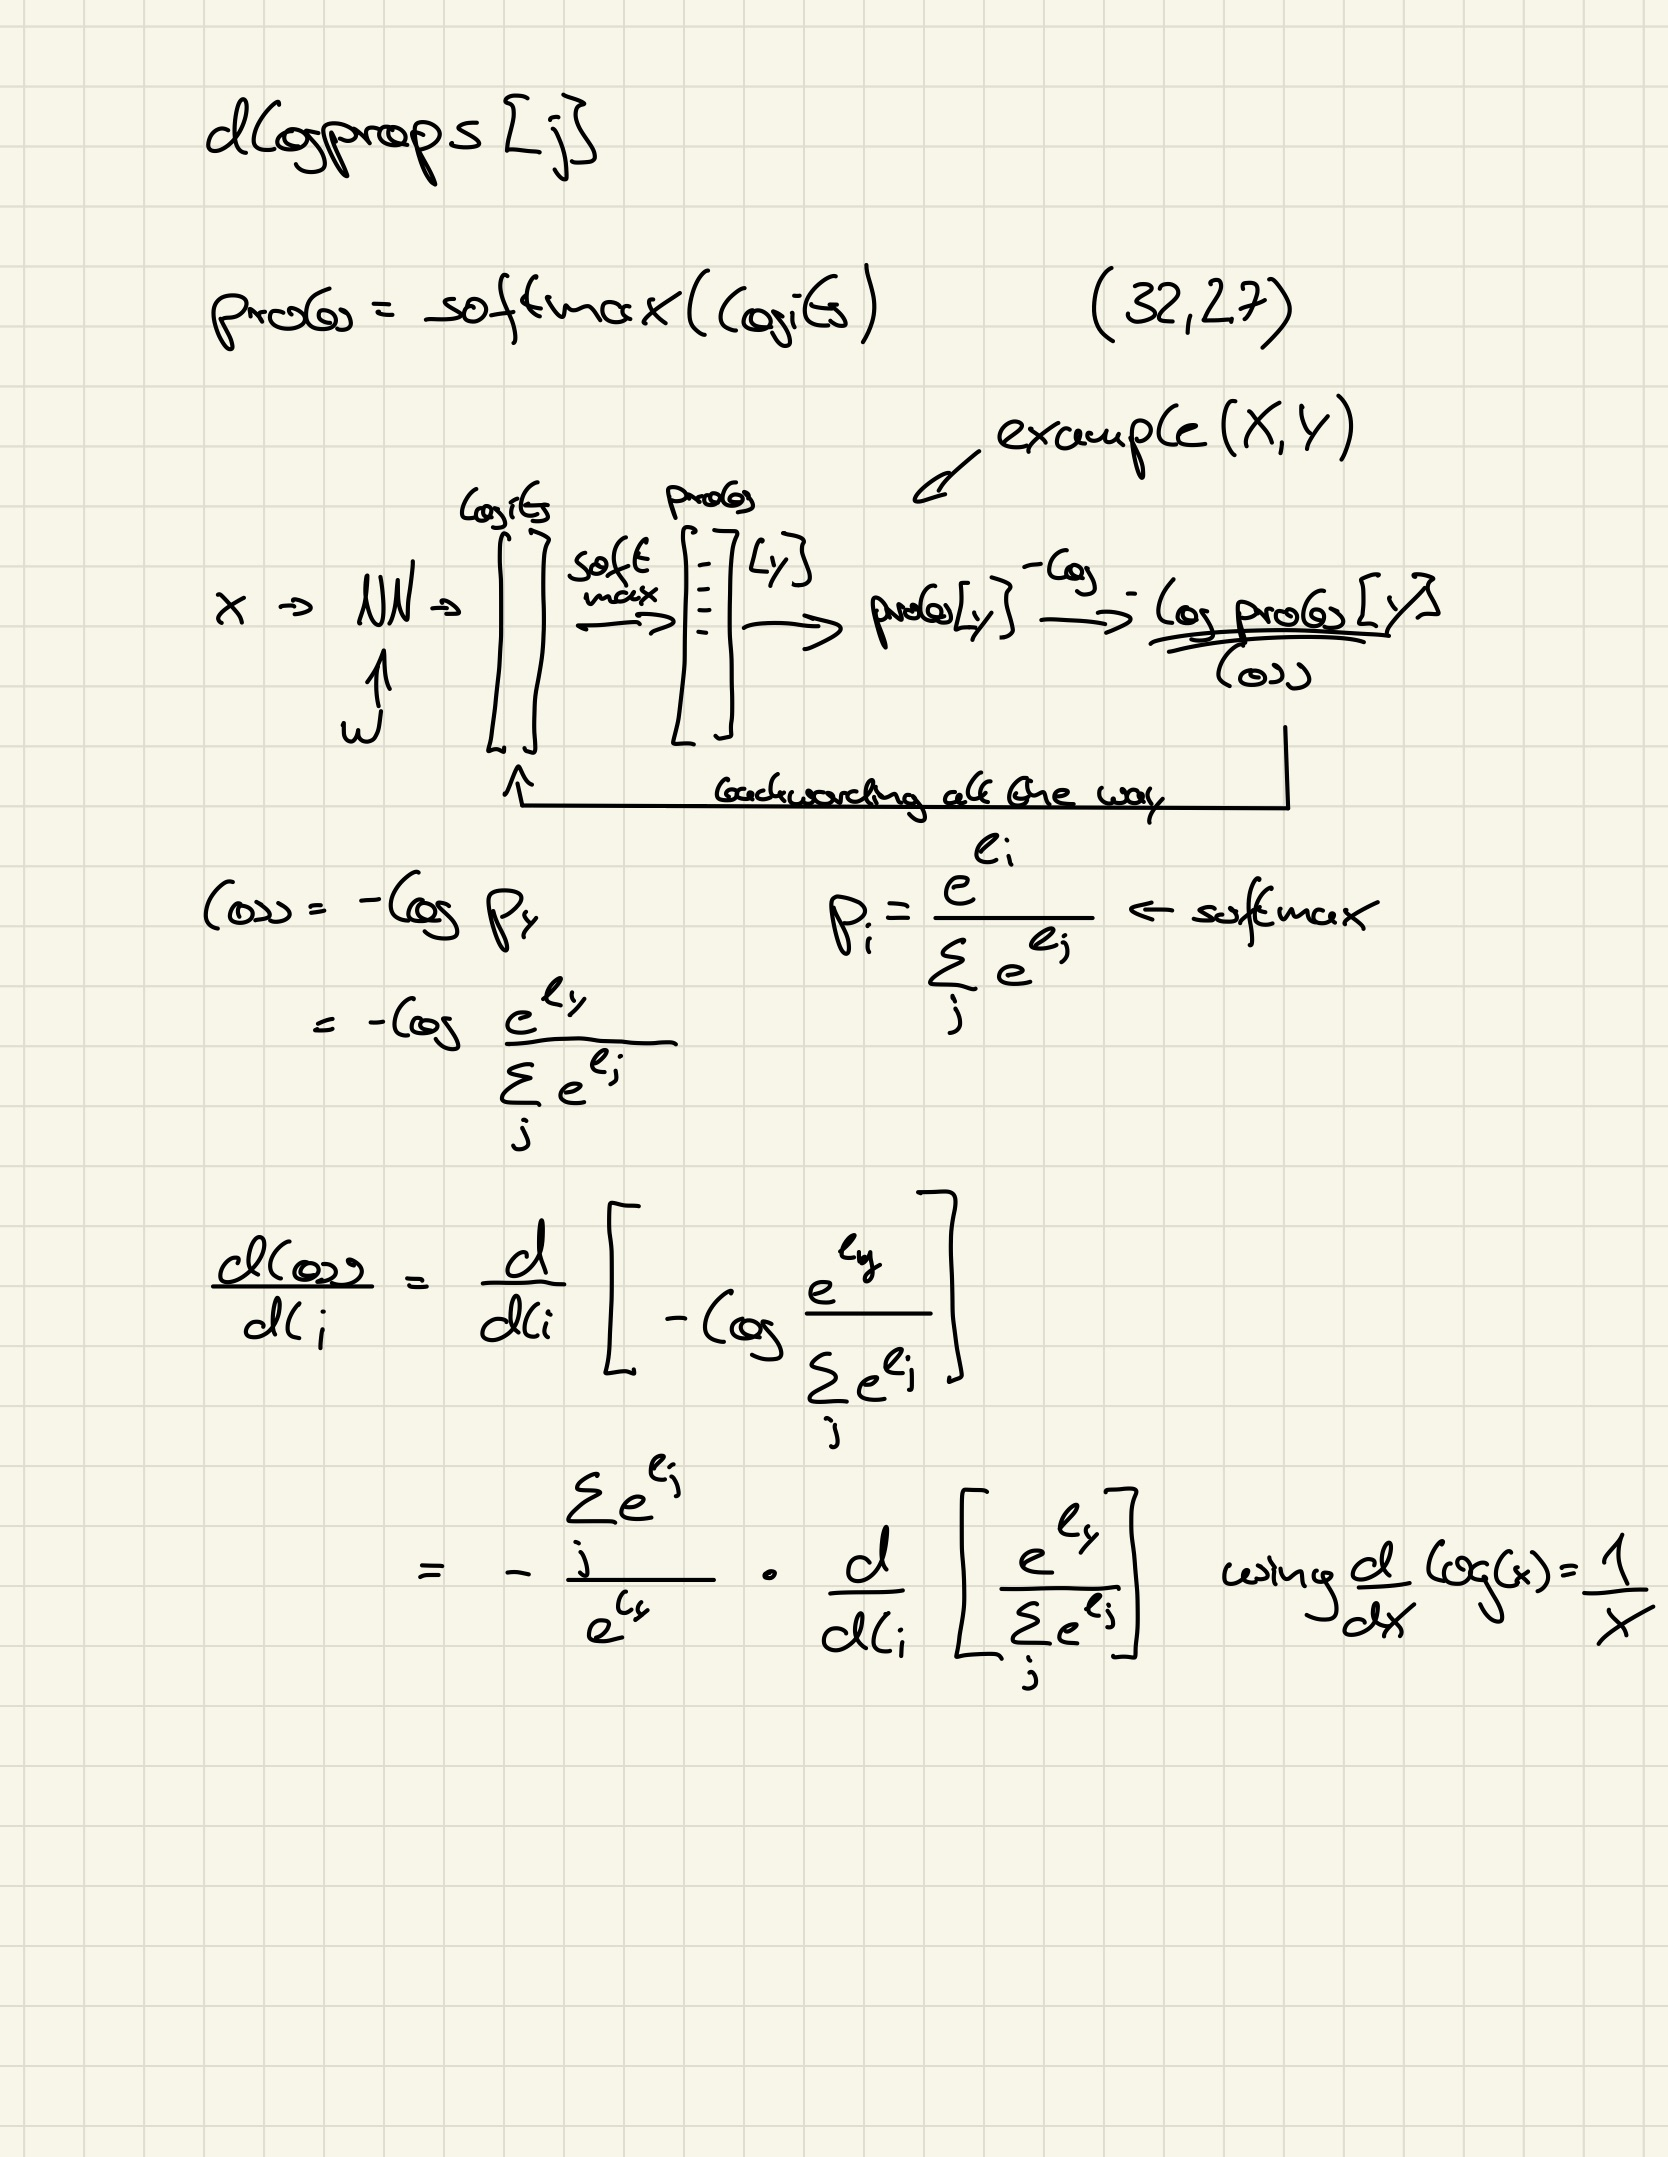

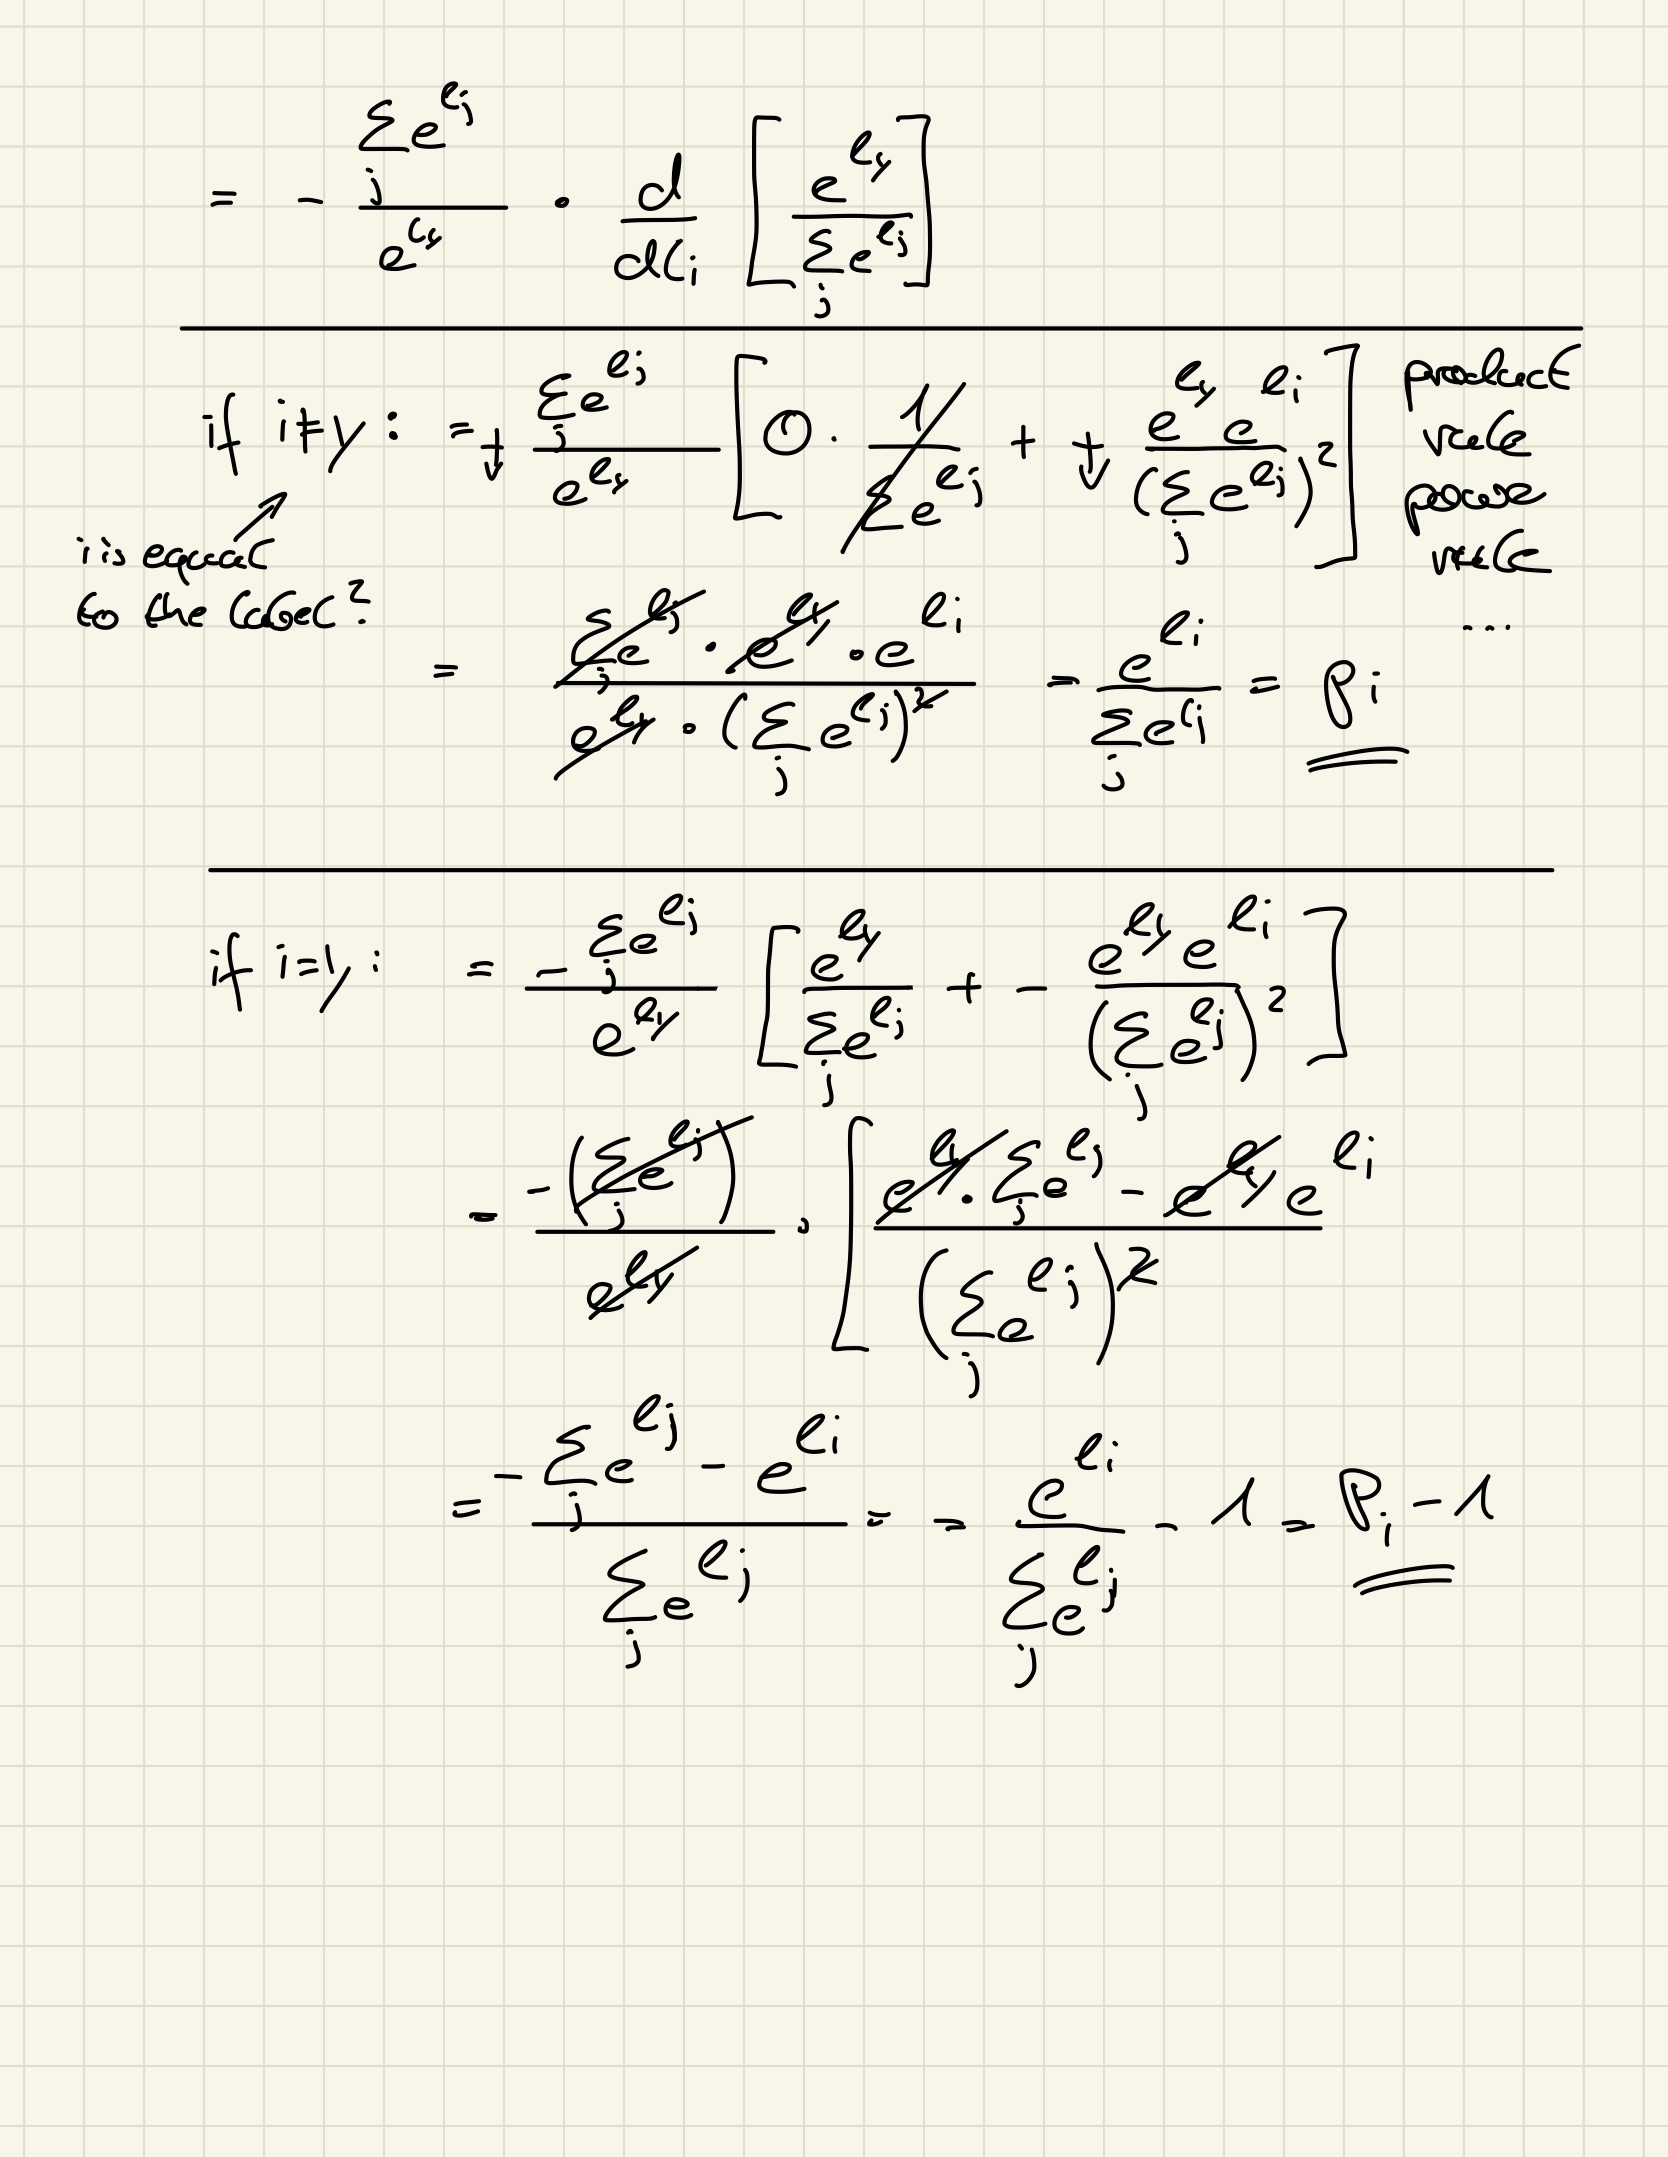

## Derivation

In [59]:
dlogits2 = F.softmax(logits, 1)
print(dlogits2.sum(1))
dlogits2[range(n), Yb] -= 1
dlogits2 /= n


tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


In [60]:
cmp('dlogits', dlogits2, logits)

dlogits         | exact:False | approximate: True  | madsiff: 7.916241884231567e-09


## Visual Expressions/ Charts and Evaluations

#### Visualization of the logits distribution in Linear Layer 2:
- every row is one sample

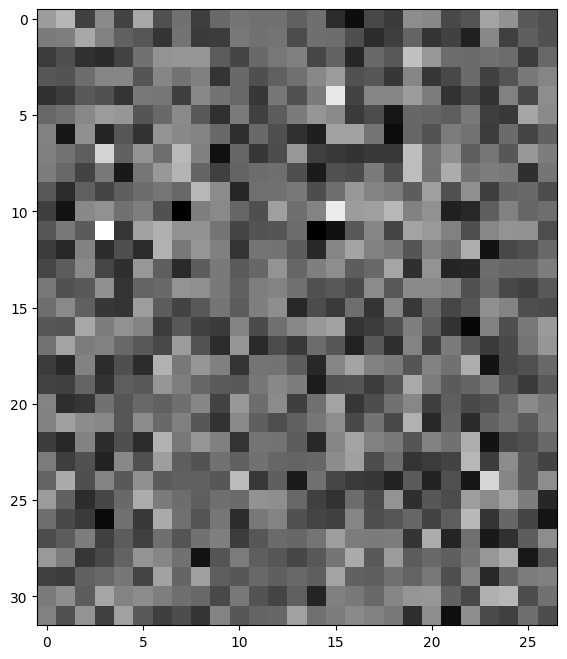

In [61]:
plt.figure(figsize=(8,8))
plt.imshow(logits.detach(), cmap='gray')

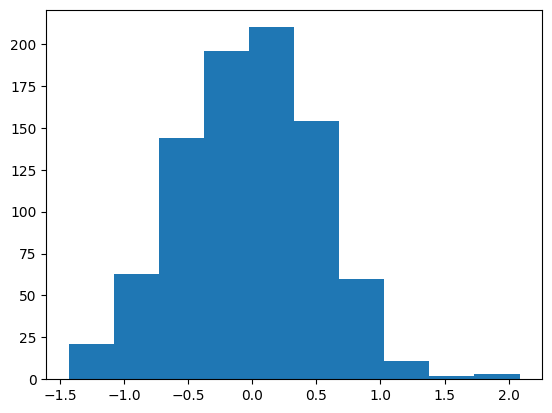

In [62]:
t2 = logits.clone()
t2 = t2.view(-1)
plt.hist(t2.detach().numpy())
plt.show()

In [63]:
testdlogits1 = F.softmax(logits, 1)
testdlogits1[0].sum()

tensor(1.0000, grad_fn=<SumBackward0>)

In [64]:
dlogits2 = F.softmax(logits, 1)
print(dlogits2.sum(1))
dlogits2[range(n), Yb] -= 1
print(dlogits2.sum(1))
dlogits2 /= n
print(dlogits2.sum(1))
dlogits2[0]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)
tensor([-5.2154e-08, -1.0431e-07,  0.0000e+00,  5.9605e-08,  7.4506e-08,
        -5.9605e-08,  2.9802e-08,  0.0000e+00, -4.4703e-08,  0.0000e+00,
        -1.4901e-08, -7.4506e-09,  4.4703e-08, -1.0431e-07,  3.7253e-08,
         5.2154e-08,  5.9605e-08, -4.4703e-08,  4.4703e-08, -1.0431e-07,
         8.9407e-08,  2.9802e-08, -1.4901e-08, -7.4506e-09, -5.9605e-08,
         0.0000e+00, -2.9802e-08, -5.9605e-08,  0.0000e+00, -9.6858e-08,
         7.4506e-08,  6.7055e-08], grad_fn=<SumBackward1>)
tensor([-1.6298e-09, -3.2596e-09,  0.0000e+00,  1.8626e-09,  2.3283e-09,
        -1.8626e-09,  9.3132e-10,  0.0000e+00, -1.3970e-09,  0.0000e+00,
        -4.6566e-10, -2.3283e-10,  1.3970e-0

tensor([ 0.0020,  0.0029,  0.0006,  0.0016,  0.0006,  0.0024,  0.0007,  0.0011,
        -0.0307,  0.0010,  0.0012,  0.0011,  0.0011,  0.0009,  0.0011,  0.0004,
         0.0003,  0.0006,  0.0005,  0.0017,  0.0016,  0.0007,  0.0008,  0.0023,
         0.0018,  0.0008,  0.0007], grad_fn=<SelectBackward0>)

### Visualization of dlogits distribution

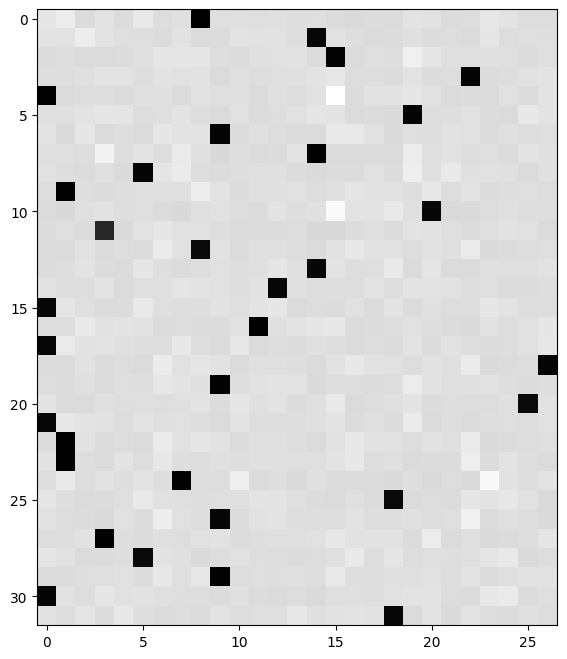

In [65]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits2.detach(),cmap = 'gray')

# Exercise 3 - Batch Normalization - Backprob Shortcut

## Introduction

Exercise 3: backprop through batchnorm but all in one go.
To complete his challenge look at the mathematical expression of the ouput of batchnorm
- take the derivative w.r.t its iput, simplify the expression, and just write it out

```
hprebn = embcat * W1 + b1

```

before:
```
bnmeani = 1/n * hprebn.sum(0, keepdim = True) # mini-batch mean for every neuron
 bndiff = hprebn - bnmeani # (32, 200)
bndiff2 = bndiff ** 2  # (32, 200)
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n), mini-batch variance
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv  # normalize (xhead)
hpreact = bngain * bnraw + bnbias # scale and shift
```

now:
```
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim = True)) / torch.sqrt(hprebn.var(0, keepdim = True, unbiased=True)+ 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())
```

In [66]:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim = True)) / torch.sqrt(hprebn.var(0, keepdim = True, unbiased=True)+ 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


## Detailed handwritten Derivation

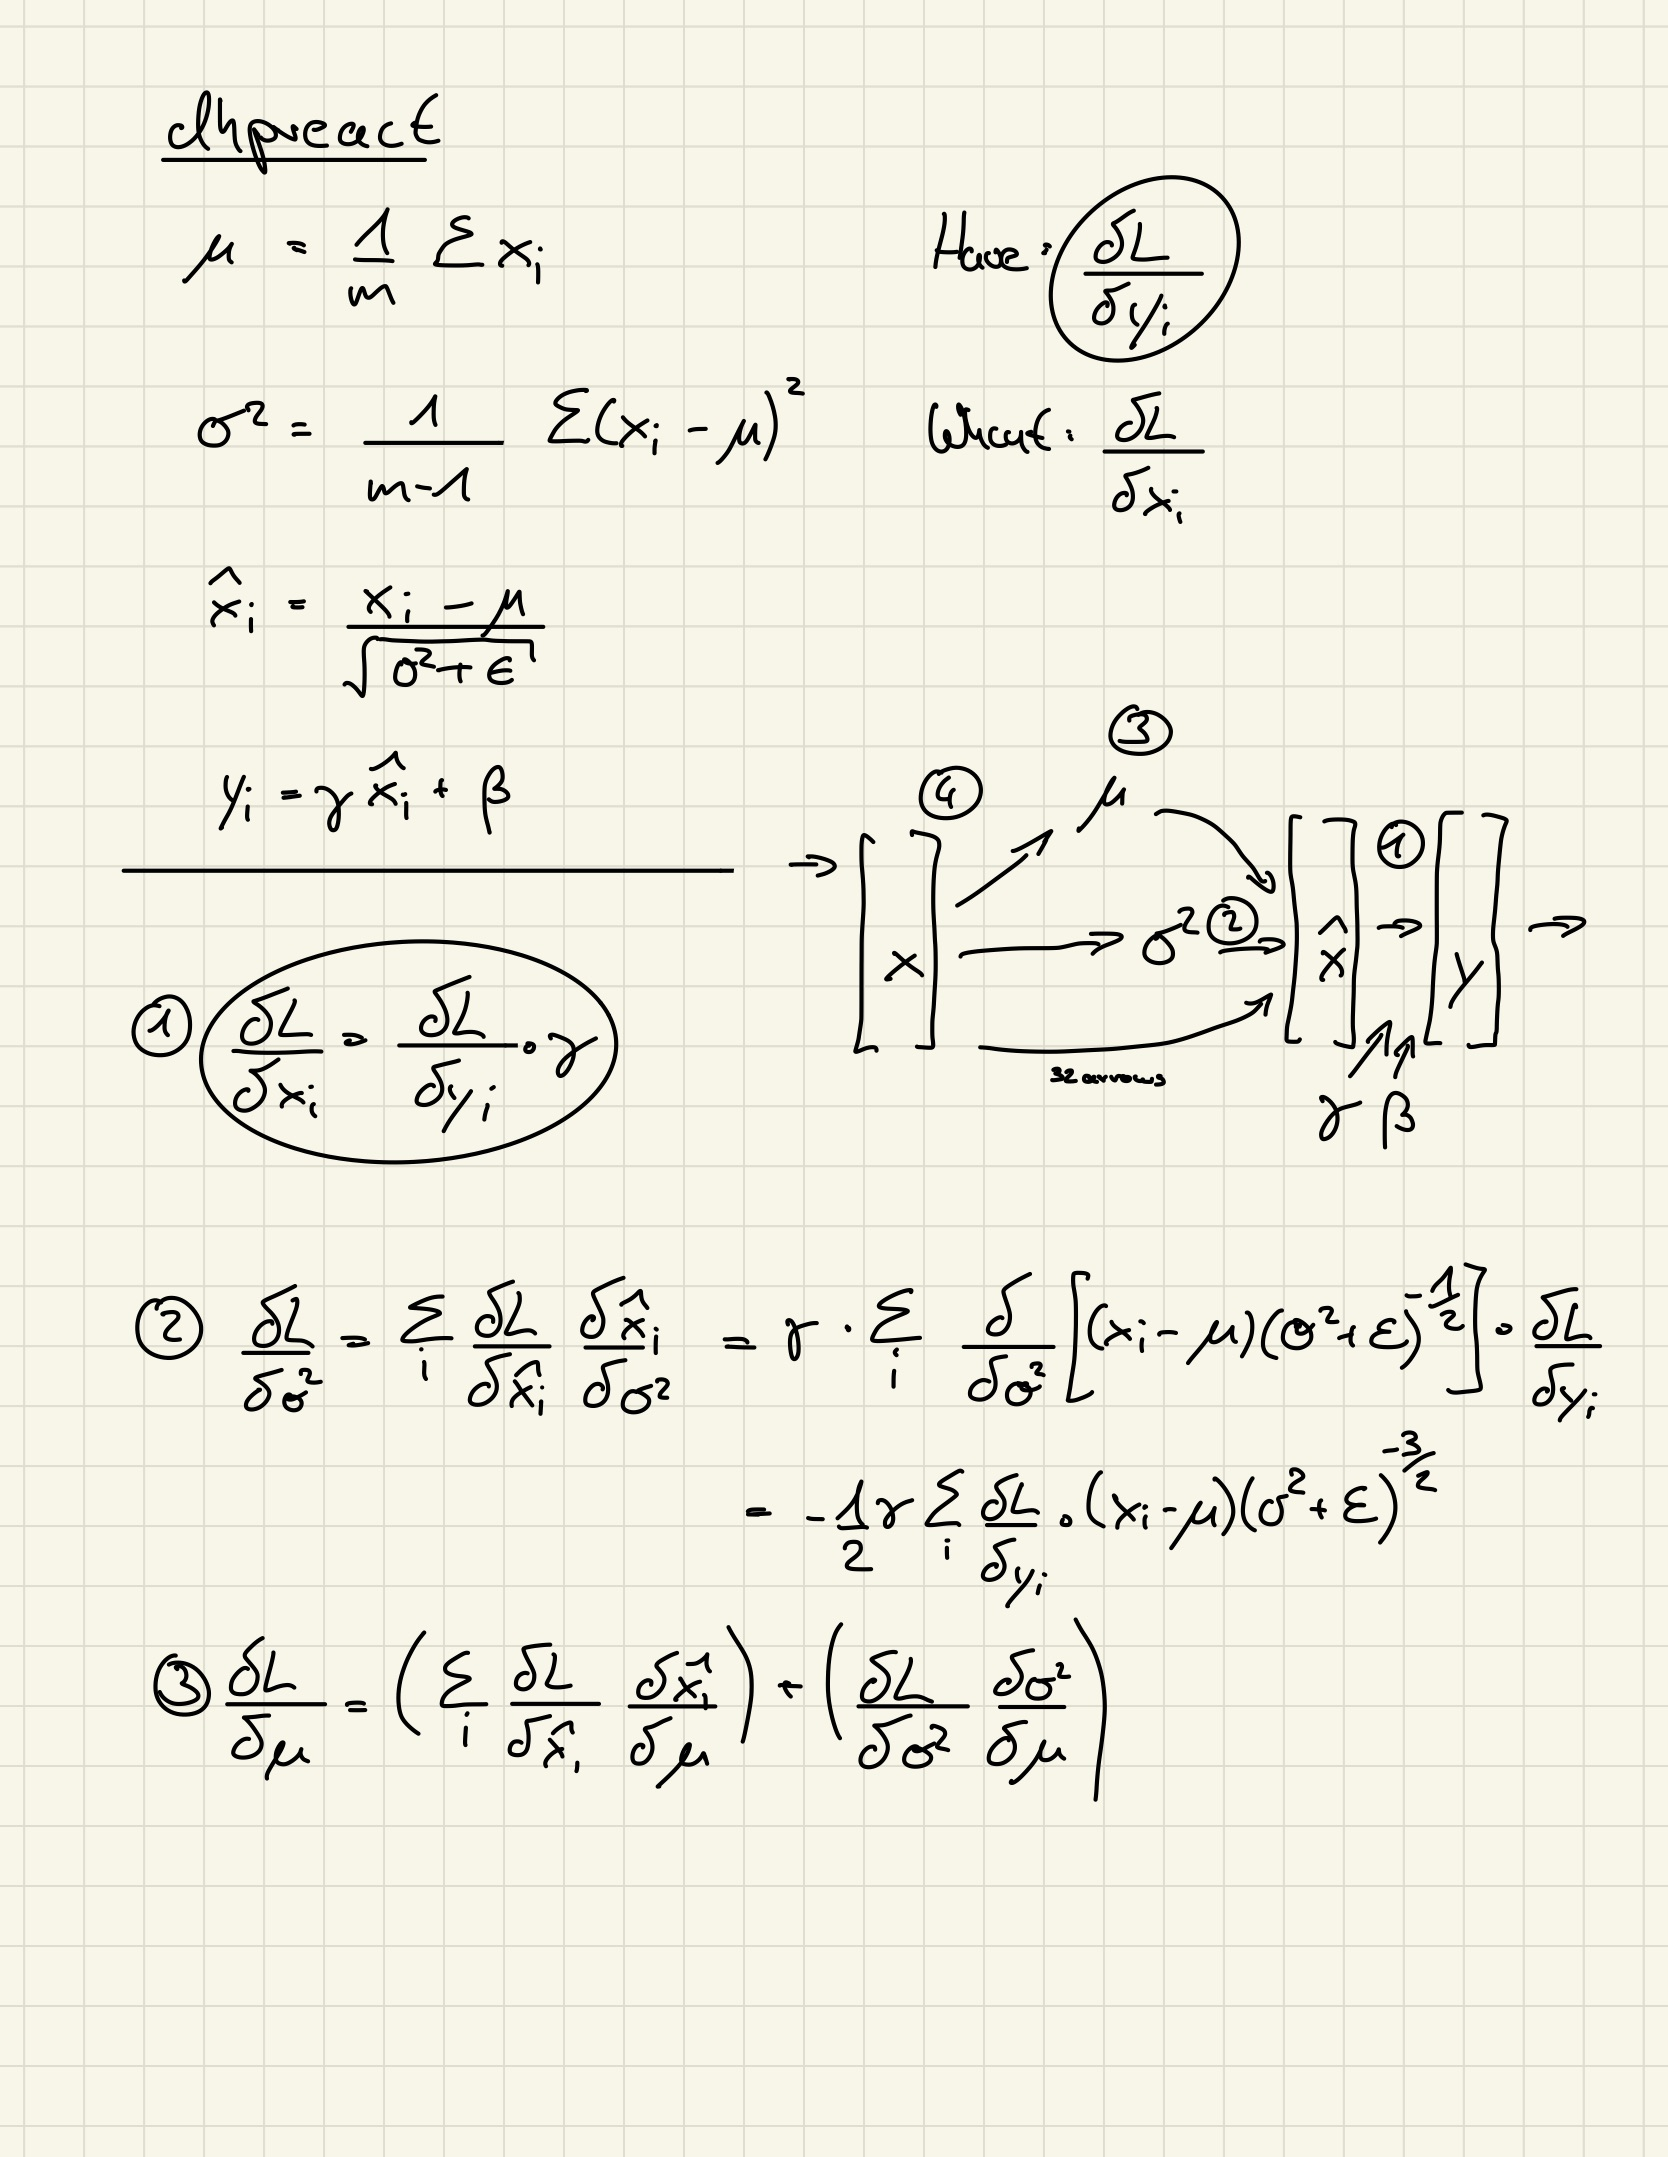

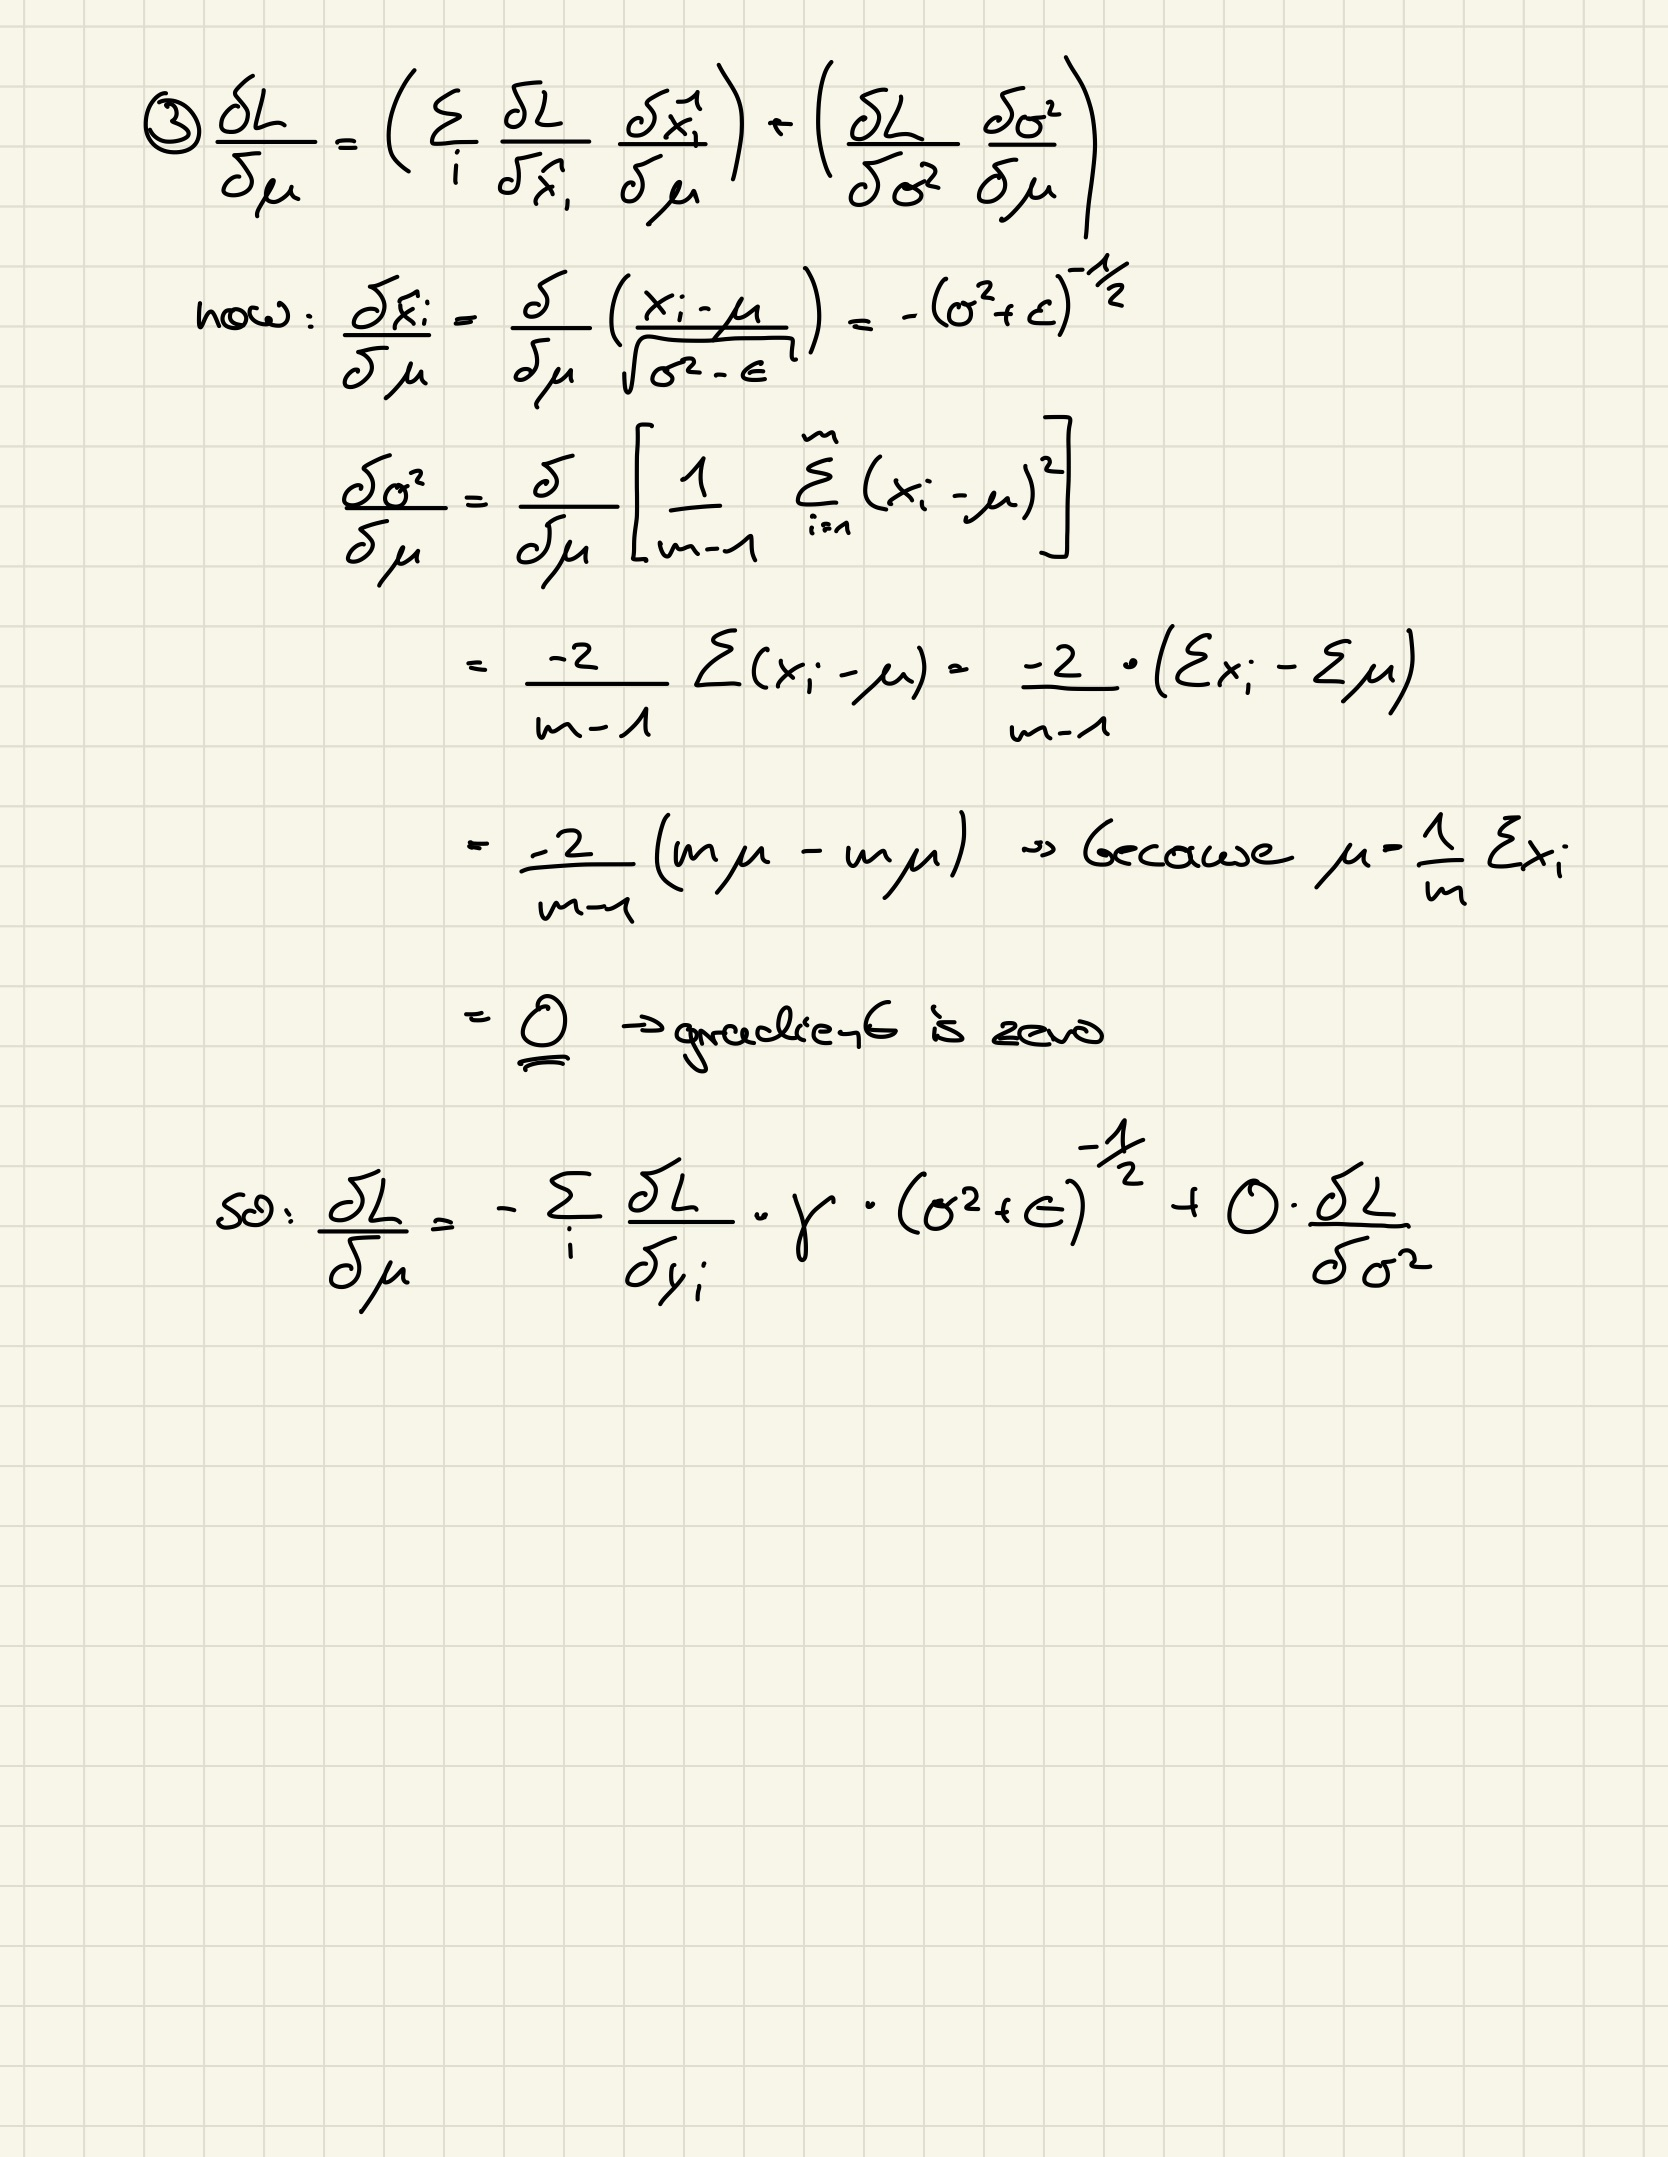

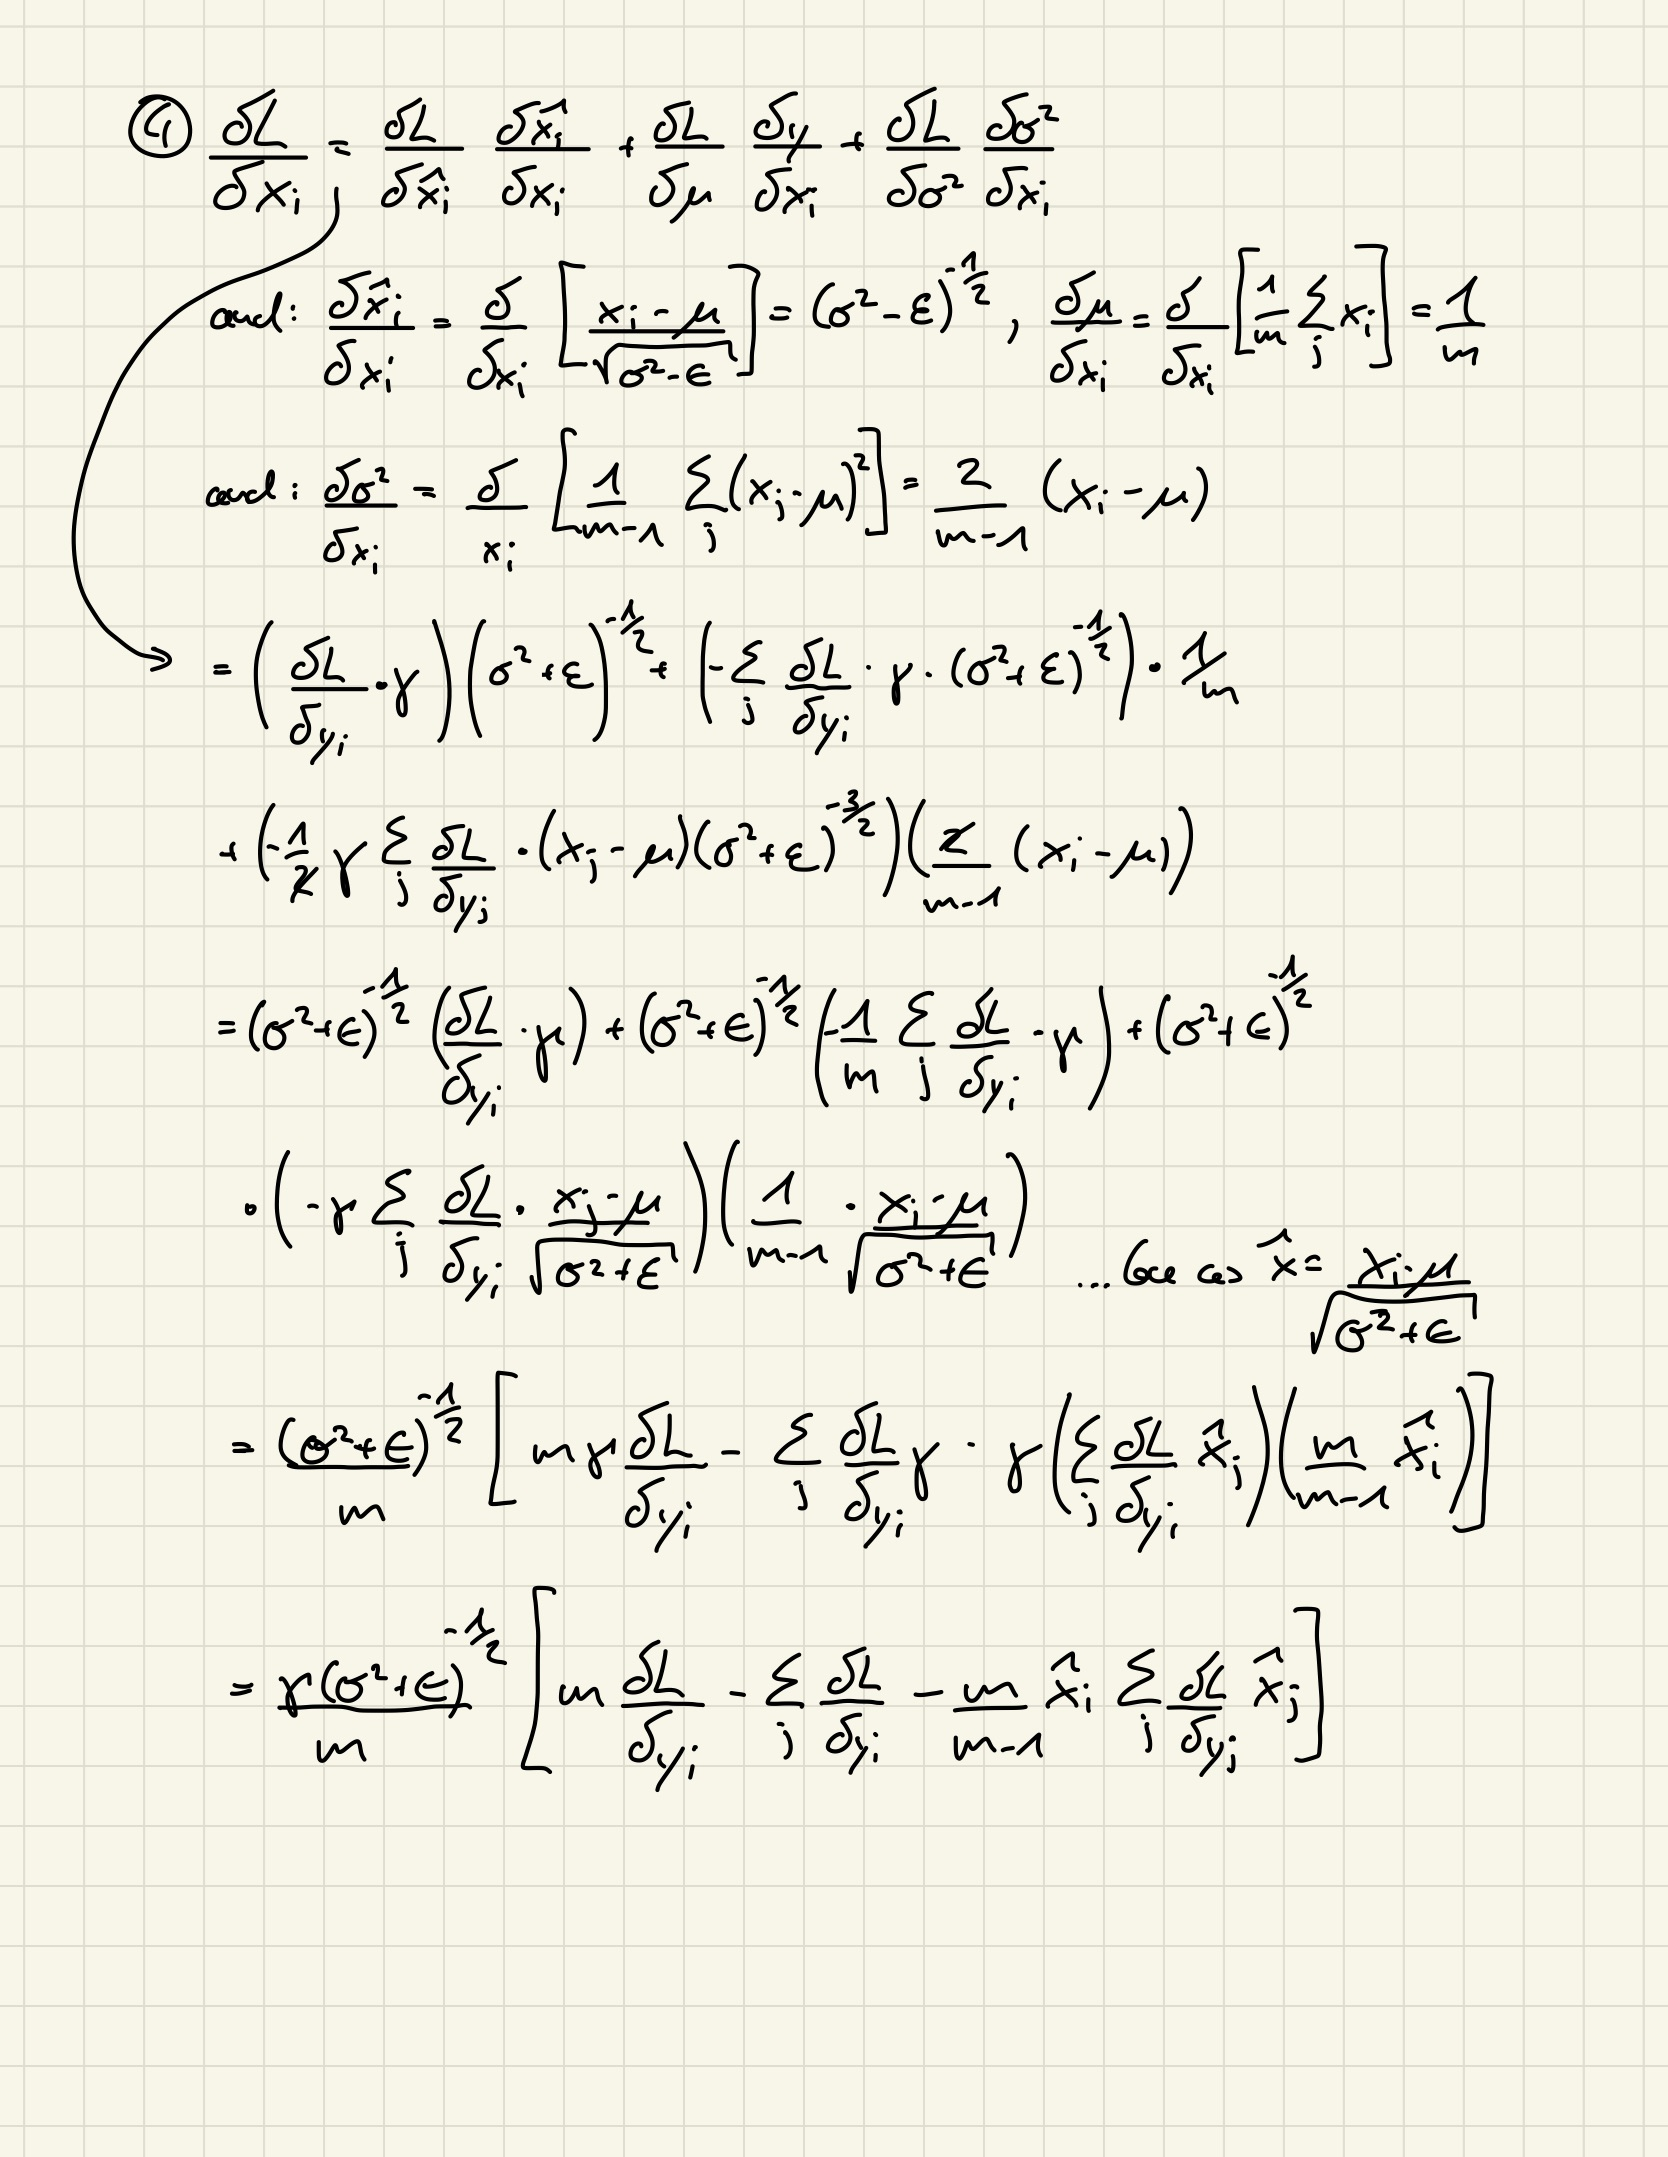

## Derivation

for comparison:
- bnmeani = $\mu_B$ -> mean for actual batch
- hpreact = $y_i$   -> new value after batch normalization

what we now wanna do:
- we have dhpreact
- we want to produce dhprebn
- for purposes of the exercise we are going to ignore $\gamma$ and $\beta$

In [67]:
dhprebn = bngain * bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)* bnraw * (dhpreact * bnraw).sum(0))
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact:False | approximate: True  | madsiff: 9.313225746154785e-10


## Visual Expressions/ Charts and Evaluations

tensor(1.6645, grad_fn=<StdBackward0>)


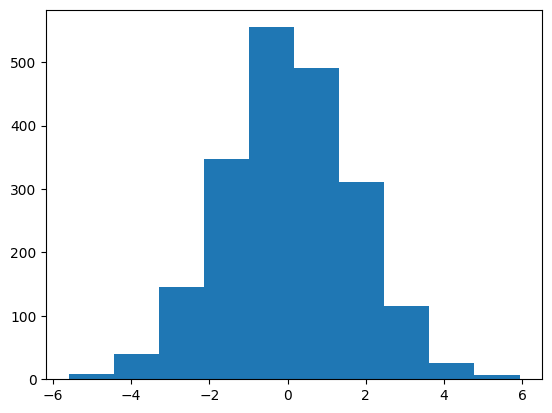

In [68]:
# before batchnormaization
t = hprebn.clone()
t = t.view(-1)
print(t.std())
plt.hist(t.detach().numpy())
plt.show()

In [69]:
bnvar

tensor([[2.9677, 1.2682, 2.1554, 1.4667, 4.6703, 2.9705, 2.0831, 1.4324, 1.3041,
         1.2941, 1.5416, 1.3771, 3.7823, 1.3272, 1.0750, 2.1390, 2.0086, 4.0767,
         0.9473, 2.6632, 5.2006, 1.3070, 2.7925, 2.8935, 1.6161, 2.7019, 1.9697,
         1.4905, 2.7771, 1.8918, 1.4346, 3.3289, 2.6032, 1.7041, 2.5652, 3.1497,
         2.4295, 3.7256, 0.3788, 1.5171, 1.6284, 2.5108, 2.3224, 1.2441, 1.9543,
         2.9438, 1.9290, 2.3941, 1.5941, 2.6831, 2.9968, 1.2193, 3.5117, 2.7399,
         3.2270, 3.6581, 1.3968, 2.2523, 2.1150, 0.7927, 1.5964, 3.3448, 2.2397,
         1.8453]], grad_fn=<MulBackward0>)

tensor(0.9845, grad_fn=<StdBackward0>)


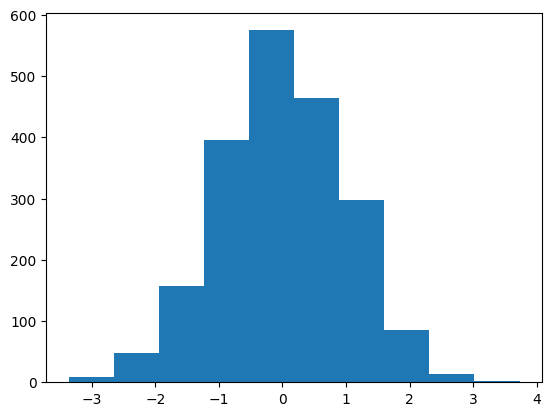

In [70]:
# bnraw -> normalised batch before shifting and squashing via (bngain and bnbias)
t = bnraw.clone()
t = t.view(-1)
print(t.std())
plt.hist(t.detach().numpy())
plt.show()

# Exercise 4 - Bring it all together

the goal here is:
  - not use pytorch autograd
  - not use loss.backward()
  - estimate gradients by ourselfs by hand

In [71]:


# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
# embedding matrix: translates discreate input to continuous vectors
C = torch.randn((vocab_size, n_embd),             generator=g)

# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * (5/3) / ((n_embd * block_size) ** 0.5)
b1 = torch.randn(n_hidden,                        generator = g) * 0.1 # using b1 just for fun, it's useless beause of BN

# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator = g) * 0.1
# we make all biases in b2 zero
b2 = torch.randn(vocab_size,                      generator = g) * 0.1

# BatchNorm parameters
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

12297


In [72]:
# same optimization as last time
max_steps = 200000
# max_steps = 10000

batch_size = 32
n = batch_size # convenience
lossi = []

In [73]:
# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

# kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embd the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

    # Linear layer 1
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation (32, 200)

    # BatchNorm layer ------------------------------------------------
    bnmean = hprebn.mean(0, keepdim = True)
    bnvar = hprebn.var(0, keepdim = True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv # normalize (xhead)
    hpreact = bngain * bnraw + bnbias # scale and shift

    # hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim = True)) / torch.sqrt(hprebn.var(0, keepdim = True, unbiased=True)+ 1e-5) + bnbias
    # ----------------------------------------------------------------

    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    # h = torch.tanh(hpreact_fast) # hidden layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # PyTorch backward pass
    #for p in parameters:
    #  p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprob here! #swole_doge_meme
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -=1
    dlogits /= n

    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    # db2 = dlogits.sum(0, keepdim = True)
    db2 = dlogits.sum(0)

    # tanh
    dhpreact = (1.0 - h**2) * dh

    # batch-norm backprob
    dbngain =(bnraw * dhpreact).sum(0, keepdim = True)
    dbnbias = dhpreact.sum(0, keepdim = True)
    dhprebn = bngain * bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)* bnraw * (dhpreact * bnraw).sum(0))

    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    #db1 = dhprebn.sum(0, keepdim=True)
    db1 = dhprebn.sum(0)

    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j] # same as Xb[k][j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]

    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
    # for grad in grads:
      # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad form .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # tracks stats
    if i % 10000 == 0: # print every once a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    #if i >= 100: # TODO: delete ealy breaking when you're ready to train full net
    #  break

      0/ 200000: 3.7969
  10000/ 200000: 2.1817
  20000/ 200000: 2.3808
  30000/ 200000: 2.4845
  40000/ 200000: 2.0027
  50000/ 200000: 2.4648
  60000/ 200000: 2.3800
  70000/ 200000: 2.0975
  80000/ 200000: 2.3705
  90000/ 200000: 2.1870
 100000/ 200000: 1.9503
 110000/ 200000: 2.3503
 120000/ 200000: 1.9788
 130000/ 200000: 2.4961
 140000/ 200000: 2.3444
 150000/ 200000: 2.1351
 160000/ 200000: 1.9105
 170000/ 200000: 1.8581
 180000/ 200000: 2.0675
 190000/ 200000: 1.8091


In [74]:
# useful for checking your gradients

#for p,g in zip(parameters, grads):
#  cmp(str(tuple(p.shape)), g, p)

In [75]:

# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [76]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0698375701904297
val 2.108875274658203


In [77]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))


mora.
mayah.
see.
mad.
ryla.
ren.
rugendraegan.
chedielin.
shi.
jen.
eden.
sana.
arleigh.
malara.
noshub.
roshirael.
kindreelynn.
novana.
ubented.
ryyah.
